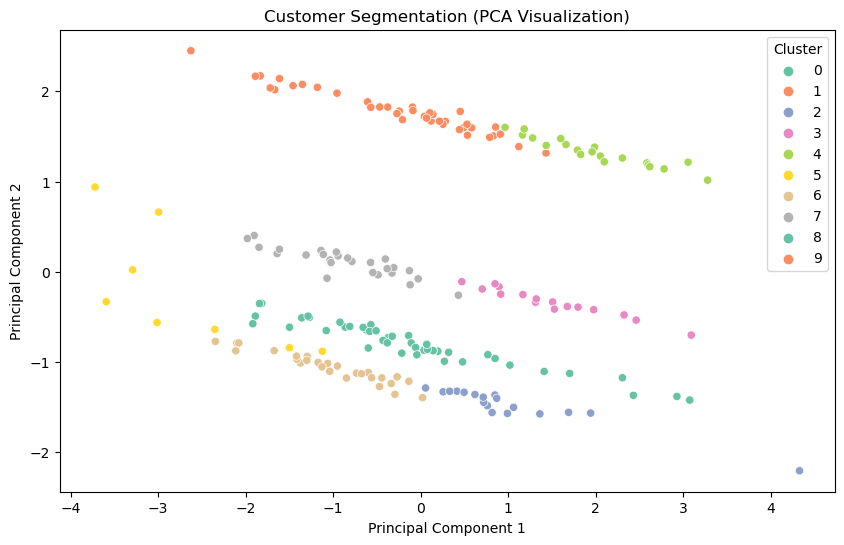

{'Optimal Number of Clusters': 10, 'Davies-Bouldin Index': 0.8982807076792947}


In [5]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Convert date columns to datetime for analysis
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Merging datasets for comprehensive analysis
merged_df = transactions_df.merge(customers_df, on='CustomerID', how='left')

# Aggregate transaction data per customer
customer_transactions = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

# Merge with customer demographic data
customer_profile = customers_df.merge(customer_transactions, on='CustomerID', how='left').fillna(0)

# Encode categorical data (Region)
customer_profile = pd.get_dummies(customer_profile, columns=['Region'], drop_first=True)

# Scaling the numerical features for clustering
scaler = StandardScaler()
features = customer_profile.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using DB Index
db_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores[k] = db_index

# Optimal number of clusters based on the lowest DB Index
optimal_k = min(db_scores, key=db_scores.get)

# Final KMeans model with optimal number of clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
customer_profile['Cluster'] = kmeans_final.fit_predict(scaled_features)

# Visualization of Clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_profile['Cluster'], palette='Set2')
plt.title('Customer Segmentation (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Save the clustering results to a CSV file
customer_clusters = customer_profile[['CustomerID', 'Cluster']]
customer_clusters.to_csv('Customer_Clusters.csv', index=False)

# Clustering metrics report
clustering_report = {
    'Optimal Number of Clusters': optimal_k,
    'Davies-Bouldin Index': db_scores[optimal_k]
}

print(clustering_report)
